# 2018-10-09 Ensemble, Gradient, Boosting...

Le noteboook explore quelques particularités des algorithmes d'apprentissage pour expliquer certains résultats numériques. L'algoithme [AdaBoost](https://fr.wikipedia.org/wiki/AdaBoost) surpondère les exemples sur lequel un modèle fait des erreurs.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Skewed split train test

Lorsqu'une classe est sous représentée, il est difficile de prédire les résultats d'un modèle de machine learning.

In [3]:
import numpy, numpy.random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

N = 1000

res = []

for n in [1, 2, 5, 10, 20, 50, 80, 90, 100, 110]:
    print("n=", n)
    for k in range(10):

        X = numpy.zeros((N, 2))
        X[:, 0] = numpy.random.randint(0, 2, (N,))
        X[:, 1] = numpy.random.randint(0, n+1, (N,))
        Y = X[:, 0] + X[:, 1] + numpy.random.normal(size=(N,)) / 2
        Y[Y < 1.5] = 0
        Y[Y >= 1.5] = 1

        X_train, X_test, y_train, y_test = train_test_split(X, Y)

        stat = dict(N=N, n=n, ratio_train=y_train.sum()/y_train.shape[0],
                    k=k, ratio_test=y_test.sum()/y_test.shape[0])
        
        for model in [LogisticRegression(solver="liblinear"),
                      MLPClassifier(max_iter=500),
                      RandomForestClassifier(n_estimators=10),
                      AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=10)]:
            obs = stat.copy()
            obs["model"] = model.__class__.__name__
            if obs["model"] == "AdaBoostClassifier":
                obs["model"] = "AdaB-" + model.base_estimator.__class__.__name__
            try:
                model.fit(X_train, y_train)
            except ValueError as e:
                obs["erreur"] = str(e)
                res.append(obs)
                continue
            sc = model.score(X_test, y_test)
            obs["accuracy"] = sc
            conf = confusion_matrix(y_test, model.predict(X_test))
            try:
                obs["Error-0|1"] = conf[0, 1] / conf[0, :].sum()
                obs["Error-1|0"] = conf[1, 0] / conf[1, :].sum()
            except Exception:
                pass
            res.append(obs)

n= 1
n= 2
n= 5
n= 10
n= 20
n= 50
n= 80
n= 90
n= 100
n= 110


In [4]:
from pandas import DataFrame
df = DataFrame(res)
df = df.sort_values(['n', 'model', 'model', "k"]).reset_index(drop=True)
df["diff_ratio"] = (df["ratio_test"] - df["ratio_train"]).abs()
df.head(n=5)

,N,n,ratio_train,k,ratio_test,model,accuracy,Error-0|1,Error-1|0,diff_ratio
0,1000,1,0.273333,0,0.300,AdaB-DecisionTreeClassifier,0.860,0.062857,0.320000,0.026667
1,1000,1,0.274667,1,0.328,AdaB-DecisionTreeClassifier,0.916,0.029762,0.195122,0.053333
2,1000,1,0.304000,2,0.284,AdaB-DecisionTreeClassifier,0.860,0.072626,0.309859,0.020000
3,1000,1,0.285333,3,0.268,AdaB-DecisionTreeClassifier,0.896,0.027322,0.313433,0.017333
4,1000,1,0.297333,4,0.256,AdaB-DecisionTreeClassifier,0.888,0.053763,0.281250,0.041333


In [5]:
df.tail(n=5)

,N,n,ratio_train,k,ratio_test,model,accuracy,Error-0|1,Error-1|0,diff_ratio
395,1000,110,0.982667,5,0.996,RandomForestClassifier,0.996,0.0,0.004016,0.013333
396,1000,110,0.990667,6,0.980,RandomForestClassifier,0.996,0.2,0.000000,0.010667
397,1000,110,0.985333,7,0.988,RandomForestClassifier,1.000,0.0,0.000000,0.002667
398,1000,110,0.985333,8,0.992,RandomForestClassifier,1.000,0.0,0.000000,0.006667
399,1000,110,0.985333,9,0.992,RandomForestClassifier,0.996,0.5,0.000000,0.006667


La répartition train/test est loin d'être statisfaisante lorsqu'il existe une classe sous représentée.

In [6]:
df[df.n==100][["n", "ratio_test", "ratio_train"]].head(n=10)

,n,ratio_test,ratio_train
320,100,0.980,0.992000
321,100,0.984,0.980000
322,100,0.988,0.984000
323,100,0.988,0.986667
324,100,0.976,0.986667
325,100,0.984,0.985333
326,100,0.984,0.981333
327,100,0.988,0.982667
328,100,0.984,0.989333
329,100,0.992,0.989333


In [7]:
#df.to_excel("data.xlsx")

In [8]:
columns = ["n", "N", "model"]
agg = df.groupby(columns, as_index=False).mean().sort_values(["n", "model"]).reset_index(drop=True)
agg.tail()

,n,N,model,ratio_train,k,ratio_test,accuracy,Error-0|1,Error-1|0,diff_ratio
35,100,1000,RandomForestClassifier,0.985733,4.5,0.9848,0.9956,0.185000,0.001216,0.004933
36,110,1000,AdaB-DecisionTreeClassifier,0.986533,4.5,0.9900,0.9972,0.130000,0.000810,0.007200
37,110,1000,LogisticRegression,0.986533,4.5,0.9900,0.9960,0.346667,0.000402,0.007200
38,110,1000,MLPClassifier,0.986533,4.5,0.9900,0.9956,0.346667,0.000810,0.007200
39,110,1000,RandomForestClassifier,0.986533,4.5,0.9900,0.9980,0.090000,0.000810,0.007200


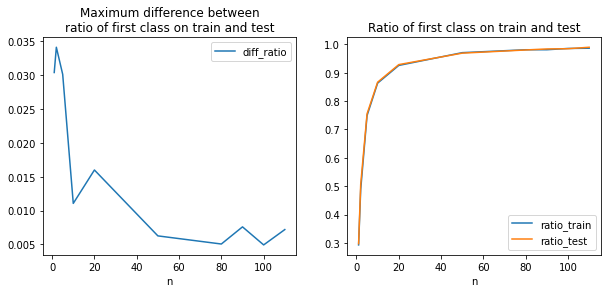

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,4))
agg.plot(x="n", y="diff_ratio", ax=ax[0])
agg.plot(x="n", y="ratio_train", ax=ax[1])
agg.plot(x="n", y="ratio_test", ax=ax[1])
ax[0].set_title("Maximum difference between\nratio of first class on train and test")
ax[1].set_title("Ratio of first class on train and test")
ax[0].legend();

Une astuce pour éviter les doublons avant d'effecturer un pivot.

In [10]:
agg2 = agg.copy()
agg2["ratio_test2"] = agg2["ratio_test"] + agg2["n"] / 100000

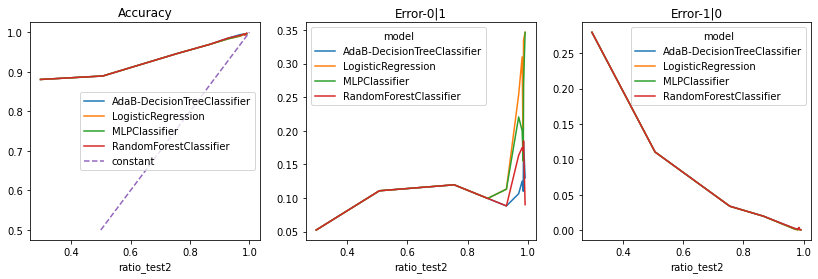

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14,4))
agg2.pivot("ratio_test2", "model", "accuracy").plot(ax=ax[0])
agg2.pivot("ratio_test2", "model", "Error-0|1").plot(ax=ax[1])
agg2.pivot("ratio_test2", "model", "Error-1|0").plot(ax=ax[2])
ax[0].plot([0.5, 1.0], [0.5, 1.0], '--', label="constant")
ax[0].set_title("Accuracy")
ax[1].set_title("Error-0|1")
ax[2].set_title("Error-1|0")
ax[0].legend();

In [12]:
agg2.pivot("ratio_test2", "model", "Error-0|1")

model,AdaB-DecisionTreeClassifier,LogisticRegression,MLPClassifier,RandomForestClassifier
ratio_test2,,,,
0.29721,0.052249,0.052249,0.052249,0.052249
0.50682,0.110686,0.110686,0.110686,0.110686
0.75525,0.119578,0.119578,0.119578,0.119578
0.86690,0.099333,0.099333,0.099333,0.099333
0.92900,0.088095,0.113095,0.113095,0.088095
0.96970,0.106349,0.253968,0.220635,0.163492
0.98120,0.125000,0.310000,0.200000,0.175000
0.98490,0.110000,0.155000,0.155000,0.170000
0.98580,0.185000,0.335000,0.268333,0.185000


Le modèle [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) construit 10 arbres tout comme la forêt aléatoire à ceci près que le poids associé à chacun des arbres des différents et non uniforme.

## Apprentissage continu

Apprendre une forêt aléatoire, puis ajouter un arbre, encore un tout en gardant le résultat des apprentissages précédents.

In [13]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = None
res = []
for i in range(0, 20):
    if model is None:
        model = RandomForestRegressor(n_estimators=1, warm_start=True)
    else:
        model.set_params(**dict(n_estimators=model.n_estimators+1))
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    res.append(dict(n_estimators=model.n_estimators, score=score))

In [16]:
df = DataFrame(res)
df.head()

,n_estimators,score
0,1,0.128906
1,2,0.323854
2,3,0.352876
3,4,0.389476
4,5,0.429992


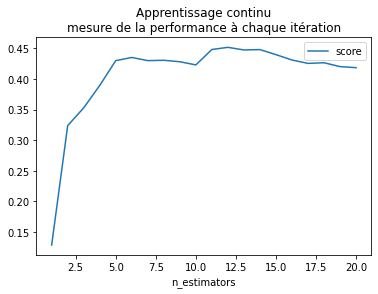

In [17]:
ax = df.plot(x="n_estimators", y="score")
ax.set_title("Apprentissage continu\nmesure de la performance à chaque itération");